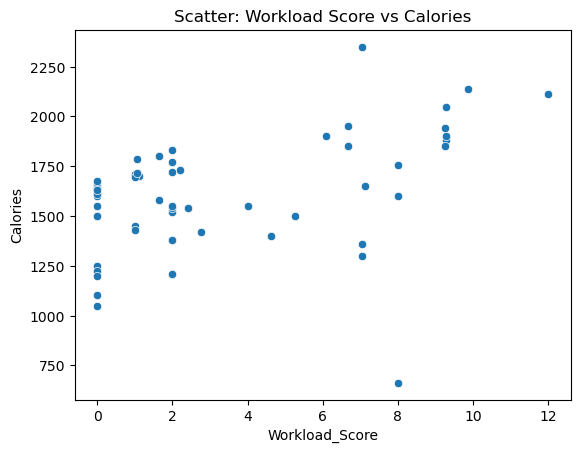

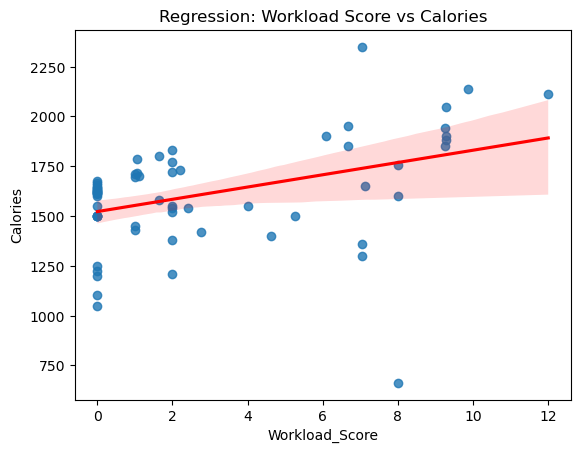

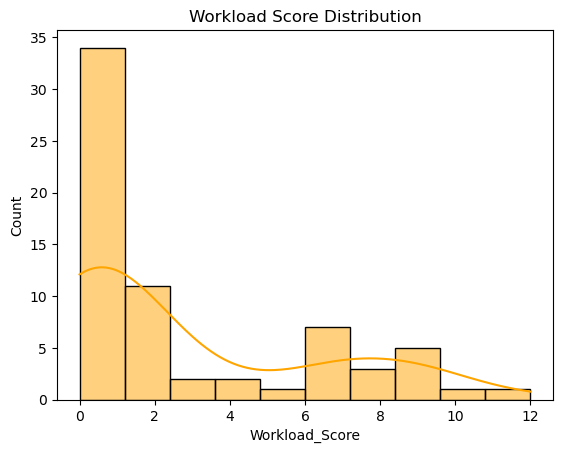

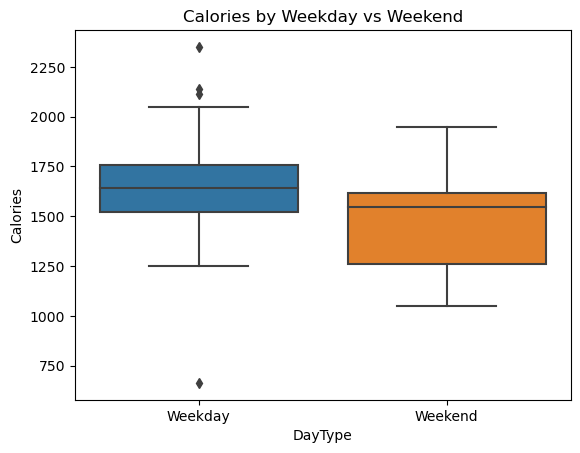

/var/folders/b7/csy304vx09sf5l63kbr0jjvm0000gn/T/ipykernel_26408/1586310111.py:112: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="DayOfWeek", y="Calories", estimator=np.mean, ci=None)


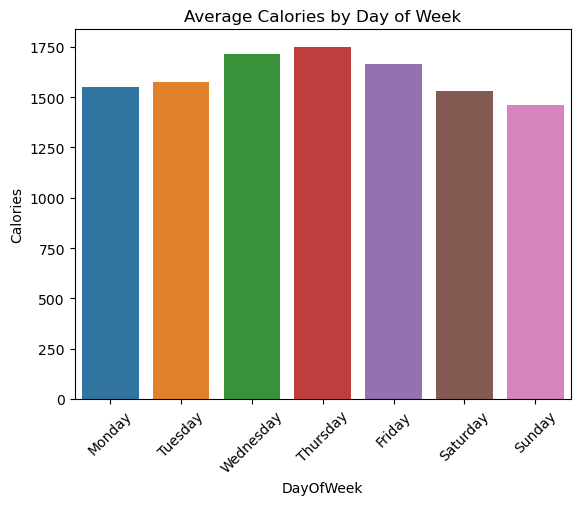

/var/folders/b7/csy304vx09sf5l63kbr0jjvm0000gn/T/ipykernel_26408/1586310111.py:118: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="DayOfWeek", y="Workload_Score", estimator=np.mean, ci=None)


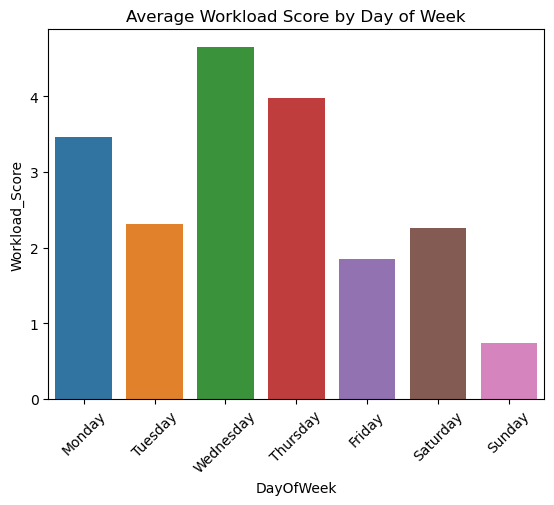

/var/folders/b7/csy304vx09sf5l63kbr0jjvm0000gn/T/ipykernel_26408/1586310111.py:130: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Workload_Level", y="Calories", estimator=np.mean, ci=None)


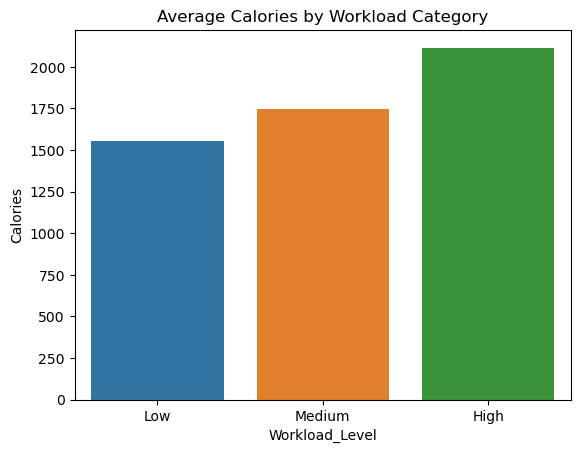

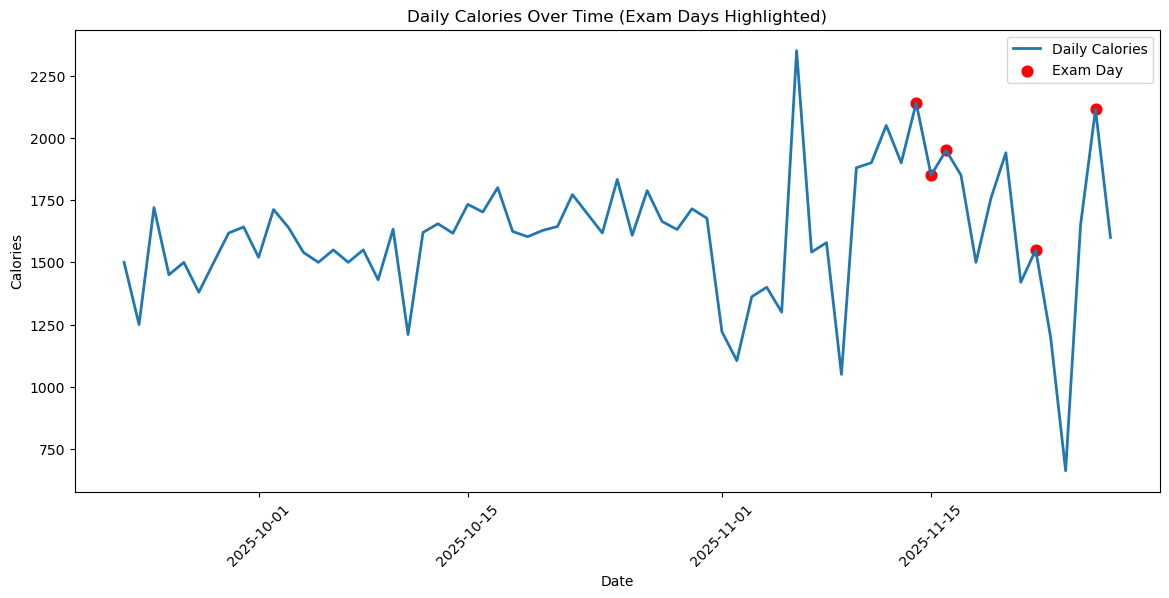

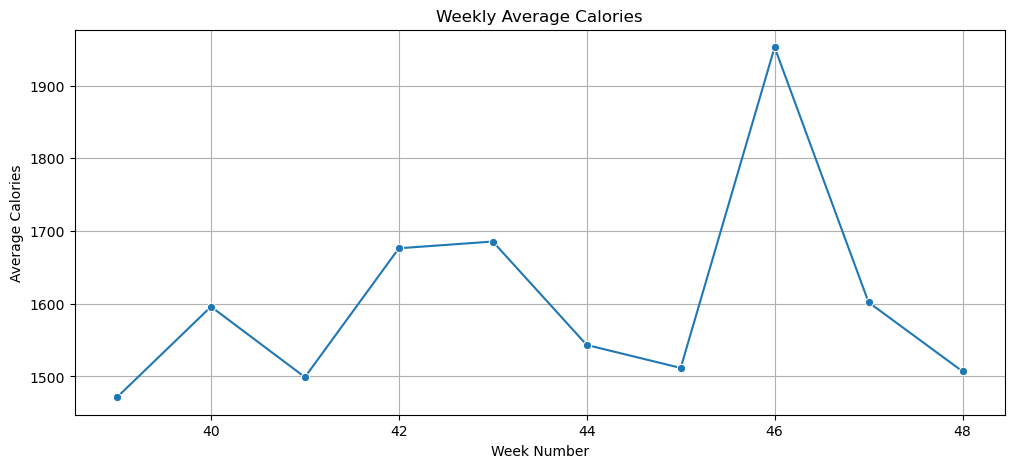

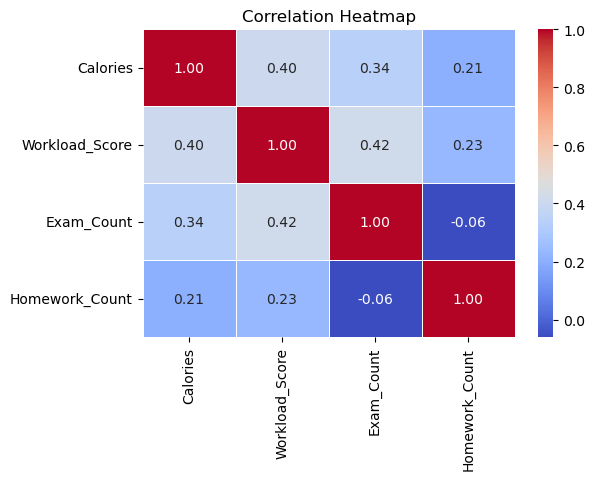


========== HYPOTHESIS TESTING ==========

Low group size: 47
High group size: 10

Improved t-Test (Low ≤3 vs High ≥8 Workload)
t-statistic: -1.7000
p-value: 0.1209

One-Way ANOVA (Low vs Medium vs High)
F-statistic: 5.9362
p-value: 0.0043




In [5]:
# -*- coding: utf-8 -*-
"""
Final Workload–Calorie Correlation System (Clean Version)
Includes:
- Daily Base Workload
- Weekly Fatigue Factor
- Final Workload Score
- Time Series, Scatter, Regression, Weekday/Weekend
- Minimal Correlation Heatmap
- Independent Samples t-Test
- One-Way ANOVA
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway


# ----------------------------------------
# 1. LOAD DATA (NOTEBOOK-FRIENDLY)
# ----------------------------------------

csv_path = "merged_november.csv"
df = pd.read_csv(csv_path)
df["Date"] = pd.to_datetime(df["Date"])

numeric_cols = ["Course_Load_Min","Homework_Count","Project_Count",
                "Exam_Count","Exam_Number_Week","Calories"]

# Convert numerics safely
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
df[numeric_cols] = df[numeric_cols].replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=numeric_cols)   # drop invalid rows


# Derived time-related features
df["DayOfWeek"] = df["Date"].dt.day_name()
df["DayType"] = df["Date"].dt.weekday.apply(lambda x: "Weekend" if x >= 5 else "Weekday")
df["Week"] = df["Date"].dt.isocalendar().week.astype(int)


# ----------------------------------------
# 2. WEEKLY FATIGUE FACTOR
# ----------------------------------------

weekly_stats = df.groupby("Week")[["Exam_Count","Homework_Count","Project_Count"]].sum().reset_index()

weekly_stats["Weekly_Fatigue_Factor"] = (
    1
    + weekly_stats["Exam_Count"] * 0.15
    + weekly_stats["Homework_Count"] * 0.05
    + weekly_stats["Project_Count"] * 0.10
)

df = df.merge(weekly_stats[["Week","Weekly_Fatigue_Factor"]], on="Week", how="left")


# ----------------------------------------
# 3. DAILY BASE WORKLOAD
# ----------------------------------------

def compute_daily_load(row):
    attendance = row["Course_Load_Min"] / 50
    hw = row["Homework_Count"] * (1.5 if row["Exam_Count"] > 0 else 1)
    project = row["Project_Count"] * (2 if row["Exam_Count"] > 0 else 1.5)
    exam_weight = 2.5 + (row["Exam_Number_Week"] * 0.7)
    exam = row["Exam_Count"] * exam_weight
    combo = 2 if (
        row["Homework_Count"] > 0 and
        row["Project_Count"] > 0 and
        row["Exam_Count"] > 0
    ) else 0
    return attendance + hw + project + exam + combo

df["Daily_Base_Workload"] = df.apply(compute_daily_load, axis=1)


# ----------------------------------------
# 4. FINAL WORKLOAD SCORE
# ----------------------------------------

df["Workload_Score"] = df["Daily_Base_Workload"] * df["Weekly_Fatigue_Factor"]


# ---------------------------------------------------------
# ========== VISUAL PLOTS ==========
# ---------------------------------------------------------

# 1. Scatter Plot
sns.scatterplot(data=df, x="Workload_Score", y="Calories")
plt.title("Scatter: Workload Score vs Calories")
plt.show()

# 2. Regression Plot
sns.regplot(data=df, x="Workload_Score", y="Calories", line_kws={"color":"red"})
plt.title("Regression: Workload Score vs Calories")
plt.show()

# 3. Workload Score Distribution
sns.histplot(df["Workload_Score"], kde=True, bins=10, color="orange")
plt.title("Workload Score Distribution")
plt.show()

# 4. Calories Weekday vs Weekend
sns.boxplot(data=df, x="DayType", y="Calories")
plt.title("Calories by Weekday vs Weekend")
plt.show()

# 5. Average Calories by Day of Week
sns.barplot(data=df, x="DayOfWeek", y="Calories", estimator=np.mean, ci=None)
plt.title("Average Calories by Day of Week")
plt.xticks(rotation=45)
plt.show()

# 6. Average Workload Score by Day of Week
sns.barplot(data=df, x="DayOfWeek", y="Workload_Score", estimator=np.mean, ci=None)
plt.title("Average Workload Score by Day of Week")
plt.xticks(rotation=45)
plt.show()

# 7. Workload Category Analysis
df["Workload_Level"] = pd.cut(
    df["Workload_Score"],
    bins=[-1, 5, 12, 30],
    labels=["Low", "Medium", "High"]
)

sns.barplot(data=df, x="Workload_Level", y="Calories", estimator=np.mean, ci=None)
plt.title("Average Calories by Workload Category")
plt.show()


# 8. Time Series Plot
plt.figure(figsize=(14,6))
plt.plot(df["Date"], df["Calories"], linewidth=2, label="Daily Calories")

exam_days = df[df["Exam_Count"] > 0]
plt.scatter(exam_days["Date"], exam_days["Calories"], color="red", s=60, label="Exam Day")

plt.title("Daily Calories Over Time (Exam Days Highlighted)")
plt.xlabel("Date")
plt.ylabel("Calories")
plt.xticks(rotation=45)
plt.legend()
plt.show()


# ---------------------------------------------------------
# 9. Weekly Average Calories (FULLY CLEAN)
# ---------------------------------------------------------

weekly_avg = df.groupby("Week")["Calories"].mean().reset_index()

# FORCE CLEANING — fixes seaborn isfinite bug forever
weekly_avg["Week"] = pd.to_numeric(weekly_avg["Week"], errors="coerce")
weekly_avg["Calories"] = pd.to_numeric(weekly_avg["Calories"], errors="coerce")
weekly_avg = weekly_avg.dropna(subset=["Week", "Calories"])

plt.figure(figsize=(12,5))
sns.lineplot(data=weekly_avg, x="Week", y="Calories", marker="o")
plt.title("Weekly Average Calories")
plt.xlabel("Week Number")
plt.ylabel("Average Calories")
plt.grid(True)
plt.show()


# ---------------------------------------------------------
# 10. Minimal Correlation Heatmap
# ---------------------------------------------------------

corr_vars = df[["Calories","Workload_Score","Exam_Count","Homework_Count"]]

plt.figure(figsize=(6,4))
sns.heatmap(
    corr_vars.corr(), 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f",
    linewidths=0.5
)
plt.title("Correlation Heatmap")
plt.show()


# ============================================================
# 11. HYPOTHESIS TESTING
# ============================================================

print("\n========== HYPOTHESIS TESTING ==========\n")

# ---- Independent Samples t-Test ----

low_group  = df[df["Workload_Score"] <= 3]["Calories"]
high_group = df[df["Workload_Score"] >= 8]["Calories"]

print("Low group size:", len(low_group))
print("High group size:", len(high_group))

if len(low_group) > 1 and len(high_group) > 1:
    t_stat, p_val = ttest_ind(low_group, high_group, equal_var=False)
    print("\nImproved t-Test (Low ≤3 vs High ≥8 Workload)")
    print(f"t-statistic: {t_stat:.4f}")
    print(f"p-value: {p_val:.4f}")
else:
    print("\n❗ t-test yapılamıyor: Gruplardan biri çok küçük.")


# ---- One-Way ANOVA ----

low  = df[df["Workload_Level"] == "Low"]["Calories"]
med  = df[df["Workload_Level"] == "Medium"]["Calories"]
high = df[df["Workload_Level"] == "High"]["Calories"]

F_stat, p_val_anova = f_oneway(low, med, high)

print("\nOne-Way ANOVA (Low vs Medium vs High)")
print(f"F-statistic: {F_stat:.4f}")
print(f"p-value: {p_val_anova:.4f}")
print("\n=========================================\n")
